In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data, sharpe_ratio

In [2]:
# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    }
]

# Initial variables
min_time = datetime.fromisoformat('2023-08-01').timestamp()
max_time = datetime.fromisoformat('2024-02-29').timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = load_cache_data(exchange, market)
        
        if exchange not in data_df_map:
            data_df_map[exchange] = {}
        data_df_map[exchange][market] = data_df

# calculate min max time
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        min_time = max(min_time, data_df["timestamp"].min())
        max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        data_df = data_df_map[exchange][market]
        data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

        data_df = data_df[
            (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
        ]

        data_df = data_df.sort_values(by='datetime', ascending=True)
        data_df = data_df.reset_index(drop=True)

        result_df = get_backtest_result(data_df, leverage)
        
        if exchange not in results:
            results[exchange] = {}
            
        results[exchange][market] = result_df

# Results are store in 'results' and 'hodl_df' variables

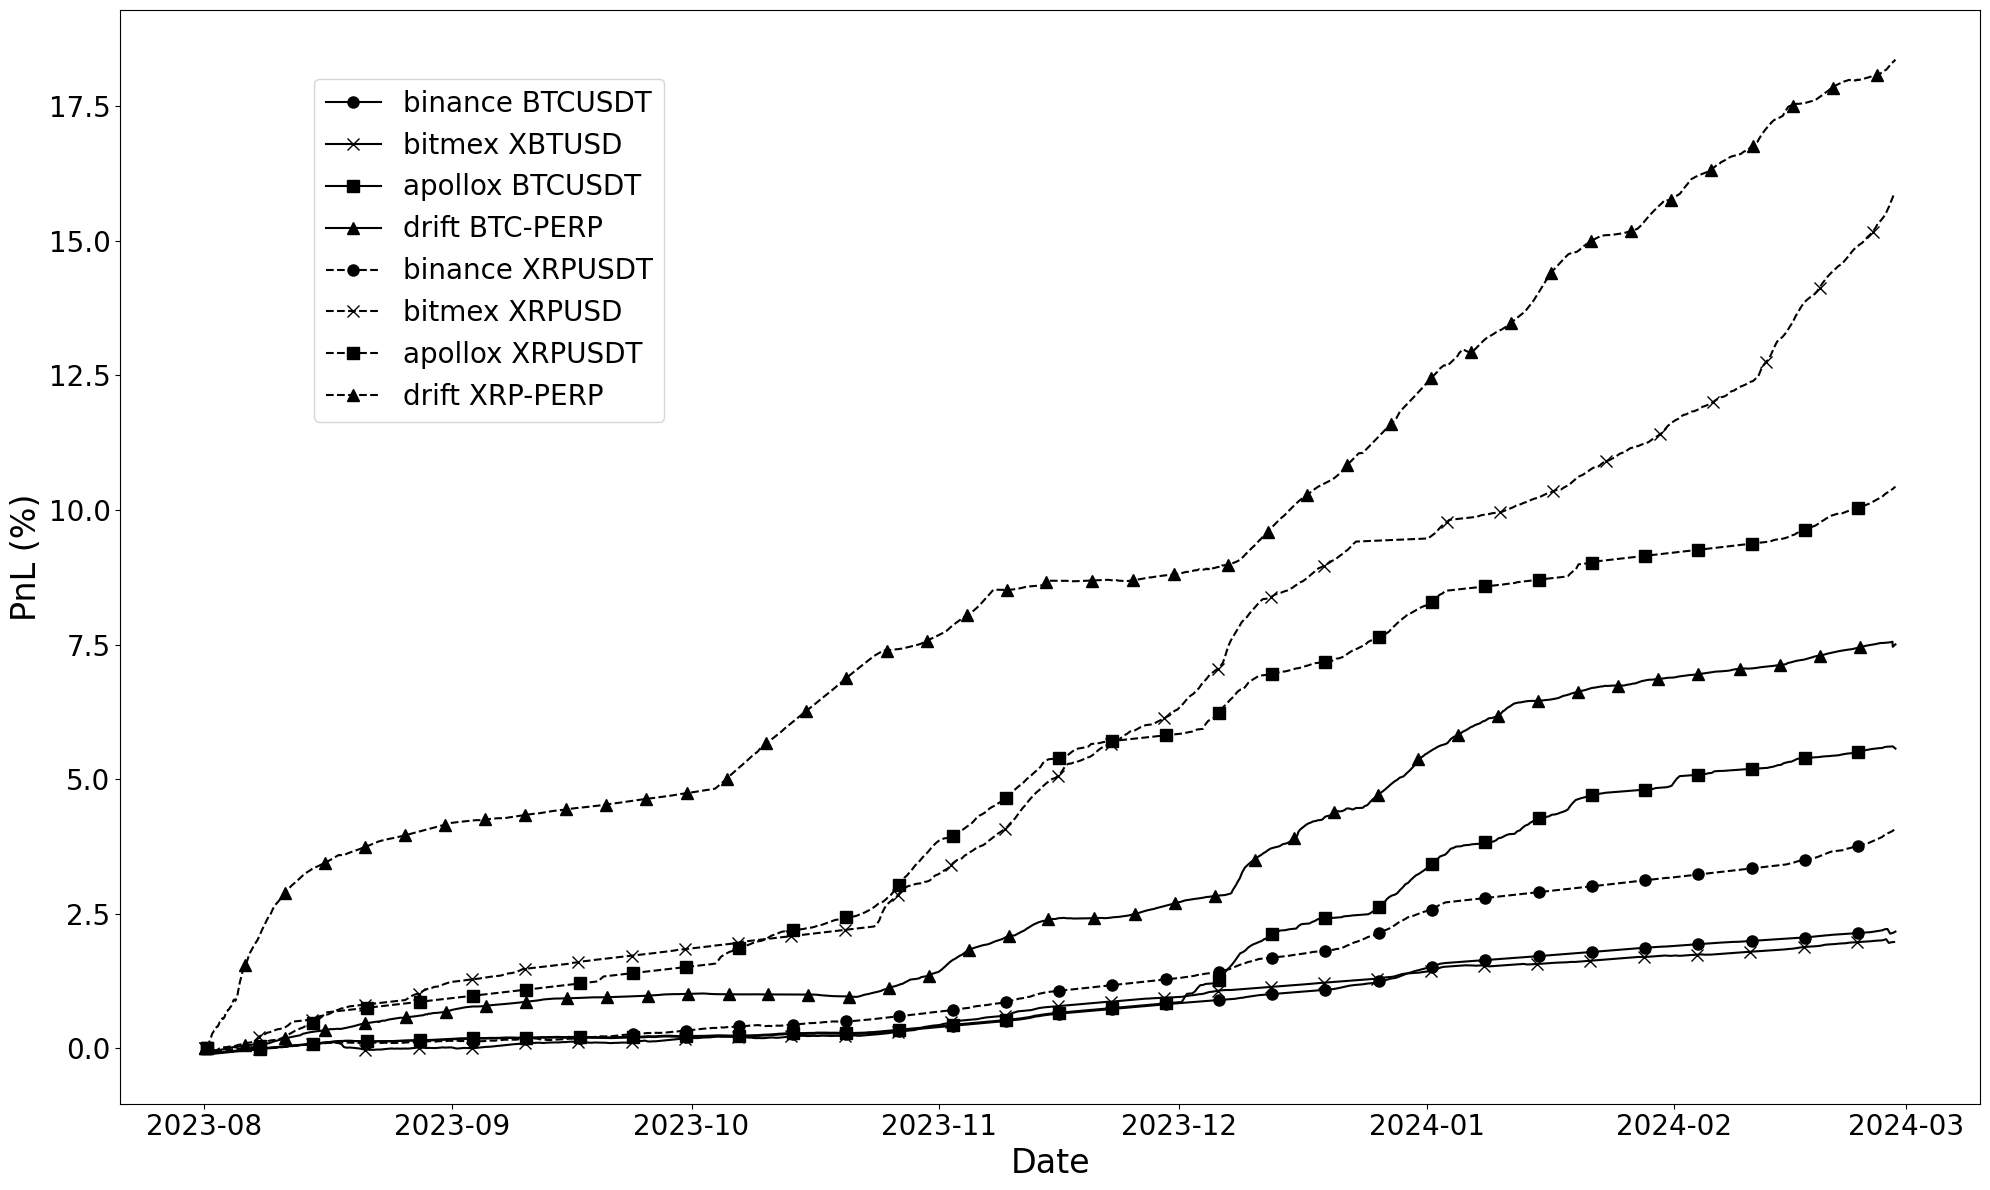

In [3]:
# Plot funding rate arb PNL only

line_styles = {
    "BTCUSDT": "-",
    "XBTUSD": "-",
    "BTCUSDT": "-",
    "BTC-PERP": "-",
    "XRPUSDT": "--",
    "XRPUSD": "--",
    "XRPUSDT": "--",
    "XRP-PERP": "--"
}

markers = {"binance": "o", "apollox": "s", "bitmex": "x", "drift": "^"}
mark_every = {"binance": 20, "bitmex": 20, "apollox": 20, "drift": 120}

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        result_df = results[exchange][market]
        line,  = ax.plot(
            result_df["datetime"],
            result_df["final_pnl"] * 100,
            label=f"{exchange} {market}",
            color="black",
            ms=8,
            marker=markers[exchange],
            markevery=mark_every[exchange],
            linestyle=line_styles[market],
        )
        
# Chart settings
lines, labels = ax.get_legend_handles_labels()
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)
ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.3, 0.95), fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig('./images/pnl_analysis.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

In [11]:

pnl = {}
max_dd = {}
sharpe = {}

# Aggregate data
for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
        result_df = results[exchange][market]
        key = f"{exchange}_{market}"
        pnl[key] = result_df['final_pnl'].iloc[-1]
        max_dd[key] = max_drawdown(result_df['final_pnl'])
        sharpe[key] = sharpe_ratio(result_df['final_pnl'])
        
    
sorted_pnl = sorted(pnl.items(), key=lambda x:x[1])
print("Sorted PNL: ")
for item in sorted_pnl:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")

print("====")
sorted_max_dd = sorted(max_dd.items(), key=lambda x:x[1])
print("Sorted Max Drawdown: ")
for item in sorted_max_dd:
    print(f"{item[0]} -> {item[1] * 100:.2f}%")
    
print("====")
sorted_sharpe_ratio = sorted(sharpe.items(), key=lambda x:x[1])
print("Sorted Sharpe Ratio: ")
for item in sorted_sharpe_ratio:
    print(f"{item[0]} -> {item[1]:.2f}")
    
print("====")
def average(list_tuple):
    data_arr = [item[1] for item in list_tuple]
    return sum(data_arr) / len(data_arr)

print(f"Average PNL: {average(sorted_pnl) * 100:.2f}%")
print(f"Average DD: {average(sorted_max_dd) * 100:.2f}%")
print(f"Average Sharpe: {average(sorted_sharpe_ratio):.2f}")

Sorted PNL: 
bitmex_XBTUSD -> 1.97%
binance_BTCUSDT -> 2.17%
binance_XRPUSDT -> 4.08%
apollox_BTCUSDT -> 5.57%
drift_BTC-PERP -> 7.50%
apollox_XRPUSDT -> 10.44%
bitmex_XRPUSD -> 15.87%
drift_XRP-PERP -> 18.37%
====
Sorted Max Drawdown: 
binance_BTCUSDT -> 0.10%
apollox_BTCUSDT -> 0.10%
binance_XRPUSDT -> 0.10%
bitmex_XRPUSD -> 0.10%
apollox_XRPUSDT -> 0.10%
drift_XRP-PERP -> 0.10%
drift_BTC-PERP -> 0.10%
bitmex_XBTUSD -> 0.14%
====
Sorted Sharpe Ratio: 
bitmex_XBTUSD -> -0.28
binance_BTCUSDT -> -0.21
binance_XRPUSDT -> 0.32
apollox_BTCUSDT -> 0.41
drift_BTC-PERP -> 0.82
bitmex_XRPUSD -> 1.02
apollox_XRPUSDT -> 1.14
drift_XRP-PERP -> 1.66
====
Average PNL: 8.25%
Average DD: 0.10%
Average Sharpe: 0.61
